# 1. Import Libraries

* Pytorch for CNN Framework 
* Pandas to load and preprocessing dataset 
* numpy for regular numerical operation 
* sklearn for splitting the dataset 
* matplotlib for plotting images

In [1]:
# Import Libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 2. Prepare Dataset

### Use Pandas to read CSV data 

In [2]:
train = pd.read_csv("../../DATA/kaggle/digit-recognation/train.csv",dtype = np.float32)

### Seperate the label from the features 

In [3]:
# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

### Split train and test data and store as tensor

In [4]:
# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42) 

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

### Visualize (Check) the data

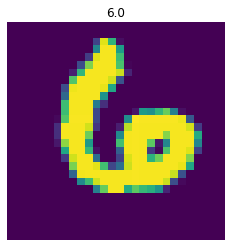

In [5]:
# visualize one of the images in data set
plt.imshow(features_train[12].reshape(28,28))
plt.axis("off")
plt.title(str(targets_train[12]))
#plt.savefig('graph.png')
plt.show()

### Create Pytorch data loader

In [6]:
# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)


# 3. Create Model

### Network Architecture: 
![CNN Architecture](cnn.png)

In [7]:
# Create CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1_1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.relu1_1 = nn.ReLU()
        self.cnn1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.relu1_2 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)
        self.relu2_1 = nn.ReLU()
        
        self.cnn2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0)
        self.relu2_2 = nn.ReLU()
        
        # Fully connected 1
        self.fc1 = nn.Linear(8192, 128) 
        self.fc2 = nn.Linear(128, 10) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1_1(x)
        out = self.relu1_1(out)
        
        out = self.cnn1_2(out)
        out = self.relu1_2(out)
        
        # Max pool 1
        out = self.maxpool1(out)
        
        # Convolution 2 
        out = self.cnn2_1(out)
        out = self.relu2_1(out)
        
        out = self.cnn2_2(out)
        out = self.relu2_2(out)
        
        #print(out.shape)
        
        # flatten
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out

# 4. Instance Model, Loss and Optimizer

In [8]:
# Create CNN
model = CNNModel()

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
print(CNNModel())

CNNModel(
  (cnn1_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu1_1): ReLU()
  (cnn1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu1_2): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (relu2_1): ReLU()
  (cnn2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (relu2_2): ReLU()
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


# 5. Training

In [17]:
from os import path

In [19]:
# CNN model training
if not (path.exists('model_weights.pth')):
    count = 0
    loss_list = []
    iteration_list = []
    accuracy_list = []
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):

            train = Variable(images.view(100,1,28,28))
            labels = Variable(labels)

            # Clear gradients
            optimizer.zero_grad()

            # Forward propagation
            outputs = model(train)

            # Calculate softmax and ross entropy loss
            loss = error(outputs, labels)

            # Calculating gradients
            loss.backward()

            # Update parameters
            optimizer.step()

            count += 1

            if count % 50 == 0:
                # Calculate Accuracy         
                correct = 0
                total = 0
                # Iterate through test dataset
                for images, labels in test_loader:

                    test = Variable(images.view(100,1,28,28))

                    # Forward propagation
                    outputs = model(test)

                    # Get predictions from the maximum value
                    predicted = torch.max(outputs.data, 1)[1]

                    # Total number of labels
                    total += len(labels)

                    correct += (predicted == labels).sum()

                accuracy = 100 * correct / float(total)

                # store loss and iteration
                loss_list.append(loss.data)
                iteration_list.append(count)
                accuracy_list.append(accuracy)
            if count % 500 == 0:
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

### Store Model 

In [10]:
torch.save(model.state_dict(), 'model_weights.pth')

### Accuracy vs Loss

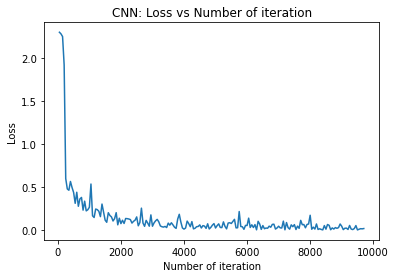

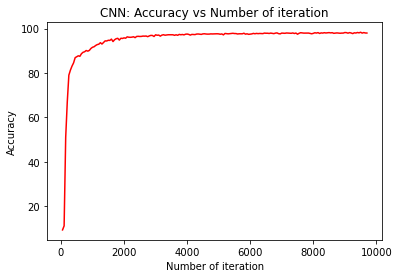

In [11]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

# 6. Testing 

### Prepare Testing data

In [12]:
test_df = pd.read_csv("../../DATA/kaggle/digit-recognation/test.csv",dtype = np.float32)
#test_df.shape

features_numpy = test_df.loc[:,:].values/255 # normalization

featuresTest = torch.from_numpy(features_numpy)

### Check Testing Data

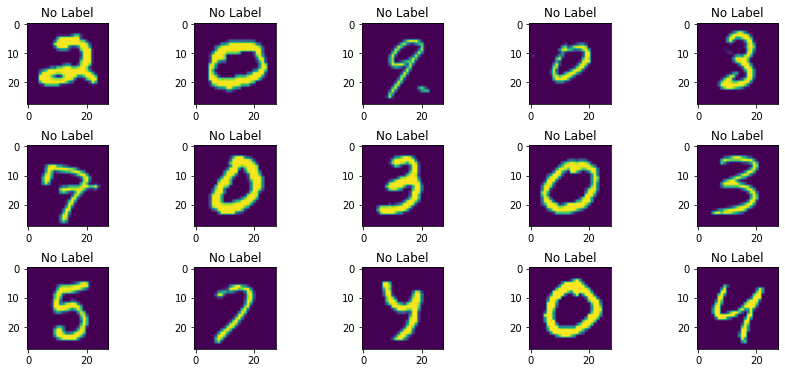

In [58]:
fig, axs = plt.subplots(3,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
ccc = 0 
for i in range(15):

    axs[ccc].imshow(featuresTest[i].reshape(28,28))
    axs[ccc].set_title("No Label")
    ccc +=1

<b>The Test Data very challenging!</b>


### Create Model and load Weights

In [14]:
# Create CNN
model = CNNModel()
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

CNNModel(
  (cnn1_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu1_1): ReLU()
  (cnn1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu1_2): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (relu2_1): ReLU()
  (cnn2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (relu2_2): ReLU()
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [15]:
#featuresTest.shape
test = Variable(featuresTest.view(28000,1,28,28))
                
# Forward propagation
outputs = model(test)

# Get predictions from the maximum value
predicted = torch.max(outputs.data, 1)[1]
print(predicted.shape)

torch.Size([28000])


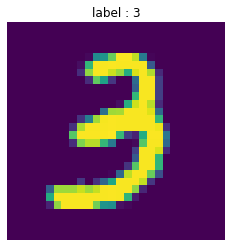

In [51]:
# visualize one of the images in data set
plt.imshow(featuresTest[7].reshape(28,28))
plt.axis("off")
plt.title("Prediction : " + str(predicted[7].numpy()))
#plt.savefig('graph.png')
plt.show()

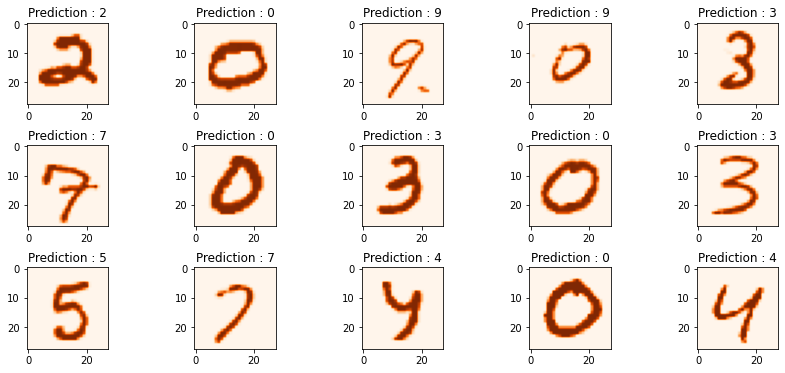

In [57]:
fig, axs = plt.subplots(3,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(15):

    axs[i].imshow(featuresTest[i].reshape(28,28),cmap=plt.cm.Oranges)
    axs[i].set_title("Prediction : " + str(predicted[i].numpy()))